# Setup
## MuJoCo Model
- For this demo I'm using a UFactory Lite 6 arm. You should be able to follow along with another arm if you're able to adapt the model XML and their Python API.
- The robot arm model in MuJoCo is specified by an XML file. It also comes 3D mesh files (used to define the appearance of the robot parts) in the `assets` folder. 
- The assets are in the mujoco_menagerie repository. git clone mujoco_menagerie into the root directory. TODO: add link
- models/lite6_viz.xml is an edited version of the lite6 model from mujoco_menagerie. Change the meshdir in line 2 to point to the `assets` folder of the corresponding model in mujoco_menagerie. 
  - If you're using a different model, a "target" body is added to visualise the target frame, and a site is added to the target and the attachemnt point. If you're not using the ufactory arm you'll have to add these changes yourself - they're commented in the model I've provided here. There is also some lighting and a floor added but these are optional.


## Dependencies
- Use conda (or a venv) to install packages:
  `conda create -n mujoco_2_real python=3.10 jupyter`
  `conda activate mujoco_2_real`
  `jupyter notebook`
- Open the jupyter link in your browser and view the notebook

## References
-  Much of this is based on the mujoco least squares colab TODO: add link

In [ ]:
! conda install mujoco numpy numpy-quaternion mediapy pathlib

In [1]:
import mujoco
from mujoco import minimize
import numpy as np
import mediapy as media
from pathlib import Path
import quaternion
np.set_printoptions(precision=4, suppress=True, linewidth=100)


Load the mujoco model first
These high level data structures are the most important:
- model: the model loaded from the XML/MJCF file, and any static information that goes with it
- data: the current state of the model, any variables that change throughout the simulatino, e.g. current sim time, joint positions and velocities, collisions
- renderer: renders an image of the scene

In [9]:
# Load model XML
model_path = "models/lite6_viz.xml"
model = mujoco.MjModel.from_xml_path(model_path)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model)

To progress the simulation, use:
- mj_step: steps the simulation forward in time - calculates forces, friction, collisions, controls - for a realisic simulation

In order to set up the scene, calculate any parameters that don't require the full calculation, or avoid constraints:
- mj_forward: computes the forward dynamics, but does not step it forward in time. Useful for setting up a scene
- mj_kinematics: computes forward kinematics (i.e. joint positions), but does not recalculate any forces, dynamics, sensors or lighting

More here: https://mujoco.readthedocs.io/en/stable/APIreference/APIfunctions.html#main-simulation


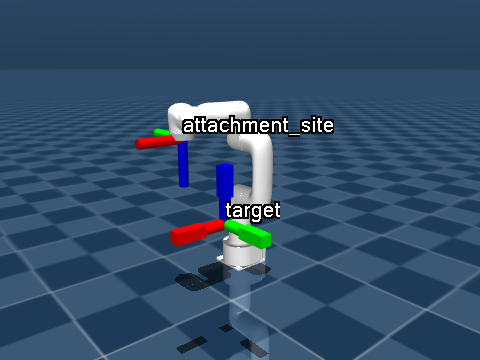

In [15]:
# Reset the model to the first keyframe defined in the XML. We could also refer to it by name
mujoco.mj_resetDataKeyframe(model, data, 0)
# Update the sim with the model's reset position
mujoco.mj_forward(model, data)

# Make a Renderer and a camera.
renderer = mujoco.Renderer(model, height=360, width=480)
camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(model, camera)
camera.distance = 1.5
camera.elevation = -15
camera.azimuth = -130
camera.lookat = (0, 0, 0.3)
camera.lookat = (0, 0, 0.3)

# Visualize site frames (the RGB axes) and labels (text)
voption = mujoco.MjvOption()
voption.frame = mujoco.mjtFrame.mjFRAME_SITE
voption.label = mujoco.mjtLabel.mjLABEL_SITE

# Call this after every physics step to update the renderer
renderer.update_scene(data, camera, voption)

media.show_image(renderer.render())


In [12]:
# Joint ranges if you're interested
print(f"Joint ranges:\n{model.jnt_range}")
bounds = [model.jnt_range[:, 0], model.jnt_range[:, 1]]

Joint ranges:
[[-6.2832  6.2832]
 [-2.618   2.618 ]
 [-0.0611  5.236 ]
 [-6.2832  6.2832]
 [-2.1642  2.1642]
 [-6.2832  6.2832]]


# Inverse Kinematics Primer
Mapping a position in cartesian space `x y z` to joint angles `theta0 theta1 ... thetak` is done through a process known as inverse kinematics. Instead of deriving it ourselvevs, we'll just use MuJoCo to calculate it for us. For an end effector pose r, the jacobian J(theta) tells us the mapping from joint angles to the position of the end effector - this is the forward kinematics.
```
r = J(theta)
```
In our case, we're looking for the inverse - we want to put the end effector in a certain pose, so we need to solve for the inverse of J
```
theta = J-1(theta)r
```
Because the kinematics are nonlinear, it's unfortnately not trivial to just invert the matrix. Also, you'll notice J-1 is a function of theta - it changes depending on the joint angles. Thus we have to use nonlinear optimisation technique to solve for it, which is usually an iterative/gradient descent type algorithm.

The simplest nonlinear optimisation algorithm is Newton-Raphson method. It iteratively follows the gradient to converge on the solution:
```
```
This can be built on with Levenberg-Marquardt optimisation, which adds a term mu to adjust the size of the steps for a quicker convergence.
```
```
A deeper explanation can be found on [this colab](), or by a web search.

Because this is an optimisation, we can add extra constraints to the equation to be optimised simultaneously.


least_squares_solver docs:

```
Nonlinear Least Squares minimization with box bounds.

  Args:
    x0: Initial guess
    residual: Vectorized function returning the residual for 1 or more points.
    bounds: Optional pair of lower and upper bounds on the solution.
    jacobian: Optional function that returns Jacobian of the residual at a given
      point and residual. If not given, `residual` will be finite-differenced.
    norm: Norm object returning norm scalar or its projected gradient and
      Hessian. See Norm class for detailed documentation.
    eps: Perurbation used for automatic finite-differencing.
    mu_min: Minimum value of the regularizer.
    mu_max: Maximum value of the regularizer.
    mu_factor: Factor for increasing or decreasing the regularizer.
    tol: Termination tolerance on the step size.
    max_iter: Maximum number of iterations.
    verbose: Verbosity level.
    output: Optional file or StringIO to which to print messages.
    iter_callback: Optional iteration callback, takes trace argument.
    check_derivatives: Compare user-defined Jacobian and norm against fin-diff.
  ```

In [6]:
def ik(x, pos=None, quat=None, radius=0.04, reg=1e-3, reg_target=None, ref_frame='attachment_site'):
  """Residual for inverse kinematics.

  Args:
      x: numpy column vector of joint angles.
      pos: target position for the end effector.
      quat: target orientation for the end effector.
      radius: scaling of the 3D cross.

  Returns:
      The residual of the Inverse Kinematics task.
  """

  # Move the mocap body to the target
  id = model.body('target').mocapid
  data.mocap_pos[id] = model.body('target').pos if pos is None else pos
  data.mocap_quat[id] = model.body('target').quat if quat is None else quat

  res = []
  # For batched operation, each column can be a different x
  for i in range(x.shape[1]):
    # Forward kinematics for given state
    data.qpos = x[:, i]
    mujoco.mj_kinematics(model, data)

    # Position residual
    res_pos = data.site(ref_frame).xpos - data.site('target').xpos
    
    # Get the ref frame orientation (convert from rotation matrix to quaternion)
    ref_quat = np.empty(4)
    mujoco.mju_mat2Quat(ref_quat, data.site(ref_frame).xmat)

    # Target quat, exploit the fact that the site is aligned with the body.
    target_quat = data.body('target').xquat

    # Orientation residual: quaternion difference.
    res_quat = np.empty(3)
    mujoco.mju_subQuat(res_quat, target_quat, ref_quat)
    res_quat *= radius

    reg_target = reg_target if reg_target is not None else x0
    res_reg = reg * (x[:, i] - reg_target)
      
    res_i = np.hstack((res_pos, res_quat, res_reg))
    res.append(np.atleast_2d(res_i).T)
  
  return np.hstack(res)


In [7]:
def ik_jac(x, res=None, radius=0.04, reg=1e-3, ref_frame='attachment_site'):
  """Analytic Jacobian of inverse kinematics residual

  Args:
    x: joint angles.
    res: least_squares() passes the value of the residual at x which is sometimes useful, but we don't need it here.
    radius: scaling of the 3D cross.

  Returns:
    The Jacobian of the Inverse Kinematics task.
    (3 + 3 + nv)  * nv
  """
  mujoco.mj_kinematics(model, data)
  mujoco.mj_comPos(model, data) #calculate CoM position

  # Get end-effector site Jacobian.
  jac_pos = np.empty((3, model.nv))
  jac_quat = np.empty((3, model.nv))
  mujoco.mj_jacSite(model, data, jac_pos, jac_quat, data.site(ref_frame).id)

  # Get the ref frame orientation (convert from rotation matrix to quaternion)
  ref_quat = np.empty(4)
  mujoco.mju_mat2Quat(ref_quat, data.site(ref_frame).xmat)
  
  # Get Deffector, the 3x3 Jacobian for the orientation difference
  target_quat = data.body('target').xquat
  Deffector = np.empty((3, 3))
  mujoco.mjd_subQuat(target_quat, ref_quat, None, Deffector)

  # Rotate into target frame, multiply by subQuat Jacobian, scale by radius.
  target_mat = data.site('target').xmat.reshape(3, 3)
  mat =  Deffector.T @ target_mat.T
  jac_quat = radius * mat @ jac_quat

  # Regularization Jacobian
  jac_reg = reg * np.eye(model.nv)

  return np.vstack((jac_pos, jac_quat, jac_reg))

Let's test both, and see the speedup that the analytical method gives us
We are solving for placing the 'attachment_site' at the position of the 'target' frame

In [16]:
# Start pose
x0 = model.key(0).qpos

# Compare time to calculate analytical vs finite differenced methods
print('Finite-differenced Jacobian:')
x_fd, _ = minimize.least_squares(x0, ik, bounds, verbose=1)
print('Analytic Jacobian:')
x_analytic, _ = minimize.least_squares(x0, ik, bounds, jacobian=ik_jac,
                                       verbose=1, check_derivatives=True)

# Assert that we got a nearly identical solution
assert np.linalg.norm(x_fd - x_analytic) < 1e-5

Finite-differenced Jacobian:
Terminated after 13 iterations: norm(dx) < tol. y: 3.636e-05, Residual evals: 168
total time 13.4ms of which residual 76.2%
Analytic Jacobian:
User-provided Jacobian matches finite-differences.
Terminated after 13 iterations: norm(dx) < tol. y: 3.636e-05, Residual evals: 90, Jacobian evals: 14
total time 7.5ms of which residual 32.7% Jacobian 47.2%


Now let's visualise the solution it has found. You can sub out x_anlaytic for x_fd to see that the same solution has been found


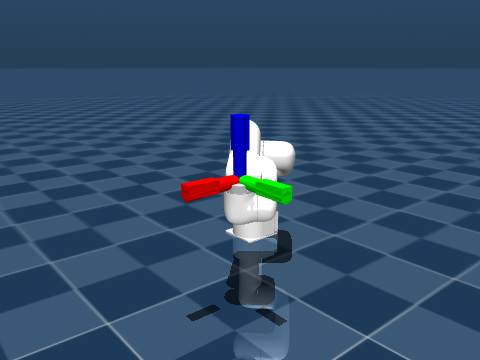

In [18]:
# Update and visualize
data.qpos = x_analytic
mujoco.mj_kinematics(model, data)
mujoco.mj_camlight(model, data)
camera.distance = 1
camera.lookat = data.site('attachment_site').xpos

# Disable the label visualisation
voption.label = mujoco.mjtLabel.mjLABEL_NONE
renderer.update_scene(data, camera, voption)

media.show_image(renderer.render())

# Trajectory
Now we let's add some motion! Here we define a basic motion that just moves the arm in a circle whilst bobbing up and down

In [19]:
# Function for generating waypoints for test motions

def spin_motion(time, speed=1, init_quat=np.array((np.sqrt(2)/2, 0, np.sqrt(2)/2, 0))):
  """
  Generate waypoints for the following motion:
  Rotate around the origin, move up and down, keep end effector facing outwards
  Args:
    time: time in seconds at which to calculate the pose
    speed: a factor by which to speed up the motion (or slow it down)
    init_quat: an initial rotation. The default gets z of the attachment facing outwards
  """

  pos = np.array((0.4 * np.sin(speed*time),
         0.4 * np.cos(speed*time),
         0.35 + 0.1 * np.sin(3 * speed*time)))
  # Angle around z axis
  theta = np.arctan2(pos[1], pos[0])
  # Convert to quaternion
  quat = np.array((np.cos(theta/2), 0, 0, np.sin(theta/2)))
  quat /= np.linalg.norm(quat)

  res_quat = np.zeros(4)
  mujoco.mju_mulQuat(res_quat, quat, init_quat)

  return pos, res_quat


Let's visualise these waypoints

In [20]:
# Render a video of the generated target path in mujoco

DURATION = 5          # seconds
FRAMERATE = 60        # Hz

# Reset the time to 0 and the robot pose to initial
mujoco.mj_resetData(model, data)

frames = []
while data.time < DURATION:
  # Move the target
  pos, quat = spin_motion(data.time)
  id = model.body('target').mocapid
  data.mocap_pos[id] = pos
  data.mocap_quat[id] = quat

  mujoco.mj_step(model, data)

  if len(frames) < data.time * FRAMERATE:
    renderer.update_scene(data, camera, voption)
    frames.append(renderer.render())


media.show_video(frames)

Looks good! Let's move the arm to each of these waypoints by solving the inverse kinematics at each

In [23]:
# Now solve for the joint angles at each pose, move the arm, and visualise the solution

DURATION = 5          # seconds
FRAMERATE = 60        # Hz
frames = []
x = x0
mujoco.mj_resetData(model, data)
data.qpos = x0

while data.time < DURATION:
  # Move the target
  # pos, quat = pose(data.time, speed=1)
  pos, quat = spin_motion(data.time, speed=1)

  x_prev = x.copy()

  # Define IK problem
  ik_target = lambda x: ik(x, pos=pos, quat=quat,
                           reg_target=x_prev)

  x, _ = minimize.least_squares(x, ik_target, bounds,
                                jacobian=ik_jac,
                                verbose=0)
  data.ctrl = x
  mujoco.mj_step(model, data)

  if len(frames) < data.time * FRAMERATE:
    renderer.update_scene(data, camera, voption)
    frames.append(renderer.render())

media.show_video(frames, loop=False)

## Utils
Before moving on to running this trajectory on the arm, we define some useful functions for interacting with the xArm API. The API takes orientations with euler angles or axis angle (no quaternions), so these are for converting between the two.

In [25]:
def quaternion_to_axis_angle(quat):
  """
  Converts a quaternion to axis-angle representation.

  Args:
    quat: A 4-element quaternion (w, x, y, z) or np.quaternion.

  Returns:
    A tuple containing the axis (a 3-element vector) and the angle (in radians).
  """

  # Extract the scalar and vector components of the quaternion
  if isinstance(quat, np.quaternion):
    w = quat.w
    x = quat.x
    y = quat.y
    z = quat.z
  else:
    w = quat[0]
    x = quat[1]
    y = quat[2]
    z = quat[3]

  # Calculate the angle
  angle = 2 * np.arccos(w)

  # Calculate the axis
  if angle == 0:
    axis = np.array([0, 0, 0])  # Zero vector if angle is zero
  else:
    axis = np.array([x, y, z]) * angle / np.linalg.norm(np.array([x, y, z]))

  return axis

In [32]:
def solve_ik(pos, quat, x0, radius=0.2, reg=0.1):
  """
  Solve for an end effector pose, return joint angles
  Args:
    radius: weighting for quaternions when solving. Higher means more importance on getting orienation right.
    reg: weighting of regularisation term. Higher means more regularisation/stability, but less adaptable
  """
  if isinstance(quat, np.quaternion):
    quat = quaternion.as_float_array(quat)

  ik_target = lambda x: ik(x, pos=pos, quat=quat,
                          reg_target=x0, radius=radius, reg=reg)
  ik_jac_target = lambda x, res: ik_jac(x, res, radius=radius, reg=reg)
  # ik_target = lambda x: ik(x, pos=pos, quat=quat, radius=0.05, reg=.1)
  x, _ = minimize.least_squares(x0, ik_target, bounds,
                              jacobian=ik_jac_target,
                              verbose=0)
  return x


def render_state(x, show=True):
  """
  Render arm position given joint angles, and optionally show the render
  """
  data.qpos = x

  mujoco.mj_kinematics(model, data)

  camera.lookat = data.site('attachment_site').xpos
  renderer.update_scene(data, camera, voption)
  pixels = renderer.render()
  if show:
    media.show_image(pixels)
  return pixels

def plot_pose(pos, quat, x0, show=True):
  """
  Solve for an end effector pose, render, and optionally show the render
  """
  x = solve_ik(pos, quat, x0)
  pixels = render_state(x, show=show)
  return x, pixels

def mujoco_to_xarm_pose(pos, quat):
  """
  Convert from position (in m) and quaternion to xarm axis-angle pose [x (mm), y (mm), z (mm), ax, ay, az]
  """
  pos_mm = np.array(pos)*1e3
  aang = quaternion_to_axis_angle(quat)
  return list(pos_mm) + list(aang)

def xarm_to_mujoco_pose(pos_aang):
  """
  Convert from xarm axis-angle pose [x (mm), y (mm), z (mm), ax, ay, az] to position (in m) and quaternion
  """
  angle = np.linalg.norm(pos_aang[3:])
  axis = pos_aang[3:]/angle

  quat = np.zeros(4)
  mujoco.mju_axisAngle2Quat(quat, axis, angle)

  pos = np.array(pos_aang)[:3]/1000.

  return pos, quat

# TESTS
# (these are not complete)

# Check that the conversion functions are legit by converting back and forth
pos, quat = spin_motion(0)
pose_xarm = mujoco_to_xarm_pose(pos, quat)
pos_recomp, quat_recomp = xarm_to_mujoco_pose(pose_xarm)
print(f"Orig: {pos}, {quat} should equal recomputed: {pos_recomp} {quat_recomp}")
print(f"Xarm axis angle: {pose_xarm}")

# ompare the np arrays
assert(np.allclose(pos, pos_recomp))
assert(np.allclose(quat, quat_recomp))
print("Success")


Orig: [0.   0.4  0.35], [ 0.5 -0.5  0.5  0.5] should equal recomputed: [0.   0.4  0.35] [ 0.5 -0.5  0.5  0.5]
Xarm axis angle: [0.0, 400.0, 350.0, -1.209199576156145, 1.2091995761561454, 1.209199576156145]
Success


## Real life
Now let's try to make the real arm do this motion! We'll start with position control as we already have the poses.
Skip this if  you don't have an arm, or adapt it to your hardware!

In [3]:
from xarm.wrapper import XArmAPI
import time
import collections
ip = "192.168.1.185"

SDK_VERSION: 1.13.30


/Users/Eugene/miniconda3/envs/ufactory/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


ROBOT_IP: 192.168.1.185, VERSION: v1.12.2, PROTOCOL: V1, DETAIL: 6,9,LI1006,DL1000,v1.12.2, TYPE1300: [0, 0]
change protocol identifier to 3



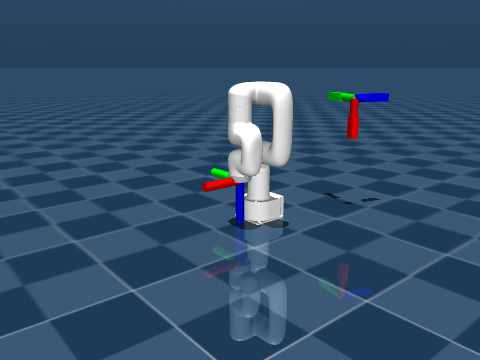

Current pos: [ 0.087 -0.     0.154], quat: [-0.  1. -0. -0.]



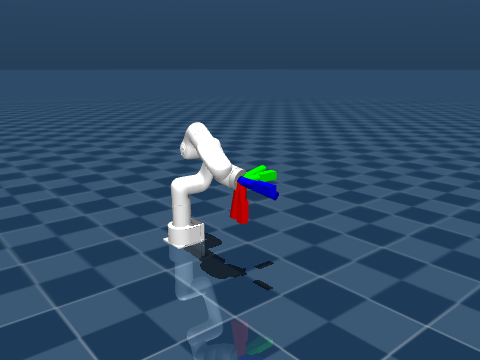

Init pos: (0.0, 0.4, 0.35), quat: [ 0.5 -0.5  0.5  0.5]


ControllerError, code: 2
servo_error_code, servo_id=1, status=3, code=0
servo_error_code, servo_id=2, status=3, code=0
servo_error_code, servo_id=3, status=3, code=0
servo_error_code, servo_id=4, status=3, code=0
servo_error_code, servo_id=5, status=3, code=0
servo_error_code, servo_id=6, status=3, code=0
ControllerError had clean
servo_error_code, servo_id=1, status=0, code=0
servo_error_code, servo_id=2, status=0, code=0
servo_error_code, servo_id=3, status=0, code=0
servo_error_code, servo_id=4, status=0, code=0
servo_error_code, servo_id=5, status=0, code=0
servo_error_code, servo_id=6, status=0, code=0


In [22]:
# Visualise current arm pose, and the new pose to get to
arm = XArmAPI(ip, is_radian=True)

x0 = model.key(0).qpos

# Apparently the reading is only valid if the code returned is 0
code, curr_xarm_aa_pose = arm.get_position_aa()
code2, state = arm.get_servo_angle()
if any((code, code2)):
  print(f"Invalid pos reading, codes: {(code, code2)}") 

curr_pos, curr_quat = xarm_to_mujoco_pose(curr_xarm_aa_pose)

# Visualise current pose in MuJoCo to compare to real life
render_state(state[:6]) # can also be used to ensure consistency with frames of reference etc.
# plot_pose(curr_pos, curr_quat, x0)
print(f"Current pos: {curr_pos}, quat: {curr_quat}")

# Visualise the pose we need to get to to start the motion
init_pos, init_quat = spin_motion(0)
x = plot_pose(init_pos, init_quat, x0)
print(f"Init pos: {init_pos}, quat: {init_quat}")


## Getting to the start position
The first challenge comes before even executing the spinning motion - we need to get to the starting pose. The simplest way is to teleoperate the robot arm to roughly the right place so it doesn't self collide.

What actually works quite well is just setting the joint angles.

For a programmatic approach, you can also create a simple screw trajectory to get it there, which is demonstrated at the end of the notebook.



In [ ]:
# TODO
arm.set_servo_angle(angle=init_x, speed=0.8, wait=True)


# Run the spinning motion

Now that we're at the start, let's spin! This first run uses the _set_position_aa_ API call to simply set the pose in cartesian coordinates and let the arm do the inverse kinematics

In [620]:
arm.set_state(state=0)

arm.set_position_aa(init_xarm_aa_pose, speed=200, radius=0, wait=True)

print("ready")

DURATION = 30
RATE = 5 

t = 0
buff_len = int(RATE / 2)
tdiff = collections.deque(maxlen=buff_len)

start_time = time.time()

while time.time() < start_time + DURATION:
    if (arm.has_error):
      print(f"Exiting, error {arm.error_code}")
      break
    
    loop_start = time.time()
    t = loop_start - start_time

    # Print the rate every 0.5s to make sure we're keeping up
    if (len(tdiff) > 0) and int(t*2) != int(t_prev*2):
      print(f"Rate: {1.0/np.array(tdiff).mean()}")

    pos, quat = spin_motion(-t, speed=0.2)
    
    arm.set_position_aa(mujoco_to_xarm_pose(pos, quat), speed=200, radius=None, wait=True)
    sleep_time = loop_start + 1.0/RATE - time.time()
    if sleep_time > 0:
      time.sleep(sleep_time)
    
    tdiff.append(t - t_prev)
    t_prev = t


ready
Rate: -0.15379211248113306
Rate: -0.3334846123192404
Rate: 1.6384428811222793
Rate: 1.346106835072945
Rate: 1.3024846338758718
Rate: 1.3075277934729663
Rate: 1.3031624721381438
Rate: 1.3037852882815015
Rate: 1.300559984756582
Rate: 1.2555242129632609
Rate: 1.218143386634619


KeyboardInterrupt: 

#### Issues with cartesian pose control
- The arm sometimes can't reset as it hits the joint limits when it tries to return, especially after doing a full rotation. Need to fully unwind
- It sometimes can't reset to the start because it linearly interpolates and self collides
- It initialises to angles that put it in a bad position for the trajectory
- Movement is stepwise, not smooth, arm doesn't keep up with instructions

Time for direct joint angle control!

In [49]:
# Use this to reset any errors
arm.reset()

servo_error_code, servo_id=2, status=3, code=0
servo_error_code, servo_id=3, status=3, code=0
servo_error_code, servo_id=4, status=3, code=0
servo_error_code, servo_id=5, status=3, code=0
servo_error_code, servo_id=6, status=3, code=0


[motion_enable], xArm is not ready to move
[motion_enable], xArm is not ready to move
[SDK][ERROR][2024-06-16 16:58:10][base.py:380] - - API -> move_gohome -> code=1, velo=0.3490658503988659, acc=8.726646259971648


In [626]:
arm.set_state(state=0)

init_x = solve_ik(*spin_motion(0), model.key(0).qpos)
arm.set_servo_angle(angle=init_x, speed=0.8, wait=True)

arm.set_state(state=1)
print("ready")

DURATION = 10
RATE = 200 

t = 0
buff_len = int(RATE / 2)
tdiff = collections.deque(maxlen=buff_len)

xprev = init_x
angles = []
start_time = time.time()
while time.time() < start_time + DURATION:
    if (arm.has_error):
      print(f"Exiting, error {arm.error_code}")
      break
    
    loop_start = time.time()
    t = loop_start - start_time

    # Print publish rate every 0.5s
    if (len(tdiff) > 0) and int(t*2) != int(t_prev*2):
      print(f"Rate: {1.0/np.array(tdiff).mean()}")

    pos, quat = spin_motion(t, speed=0.5)
    x = solve_ik(pos, quat, xprev)
    angles.append(x)
    
    arm.set_servo_angle(angle=x, wait=False)
    # render_state(x)
    sleep_time = loop_start + 1.0/RATE - time.time()
    if sleep_time > 0:
      time.sleep(sleep_time)

    tdiff.append(t - t_prev)
    t_prev = t
    xprev = x.copy()
    

ready
Rate: -11.148711736080427
Rate: 155.3743439021472
Rate: 166.32565900873286
Rate: 161.83738874968265
Rate: 180.12274428074437
Rate: 182.66410705762254


KeyboardInterrupt: 


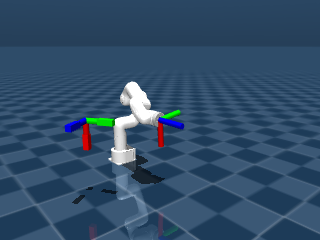
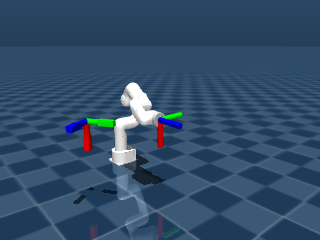
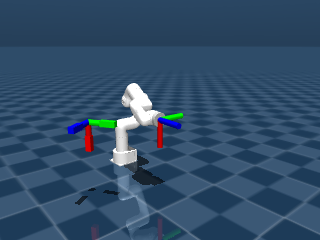
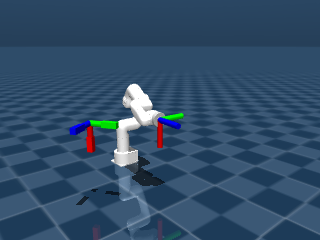
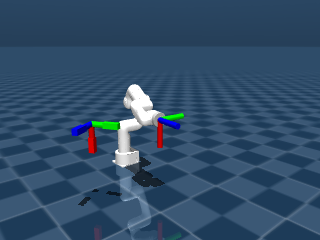
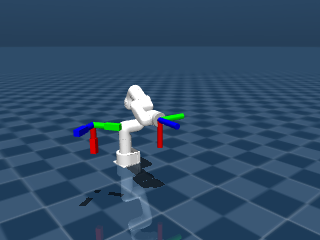
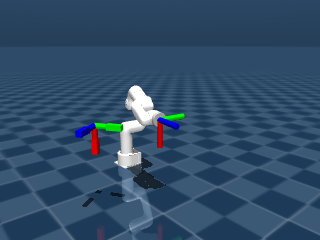
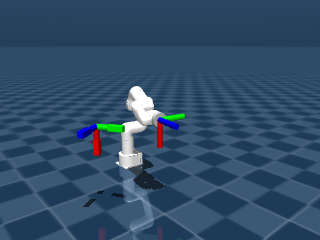
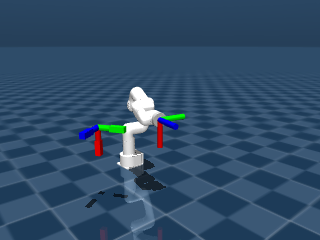
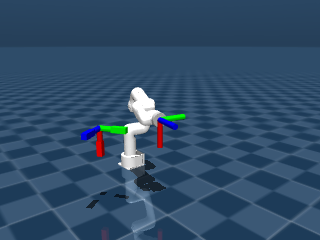
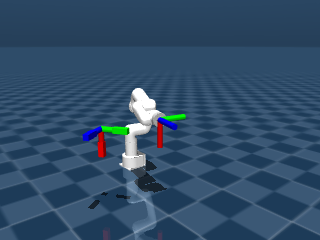
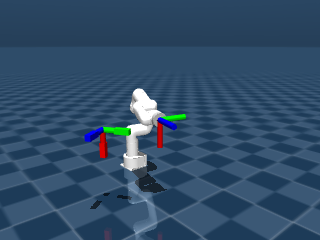
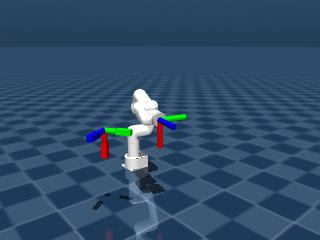
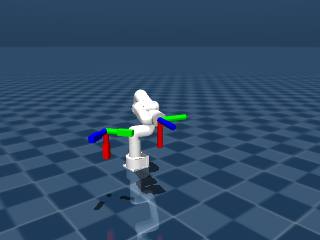
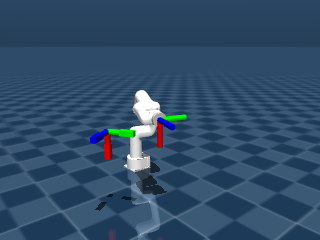
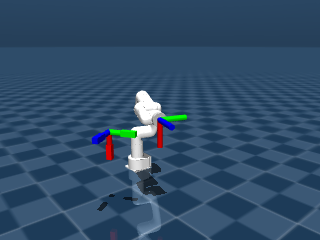
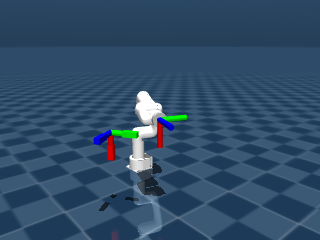
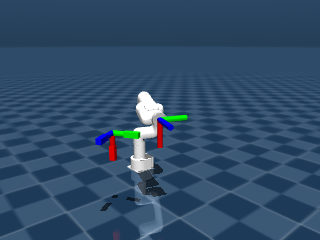
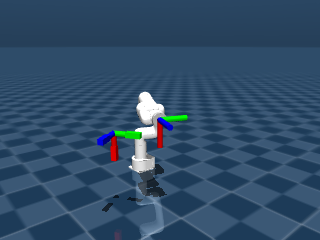
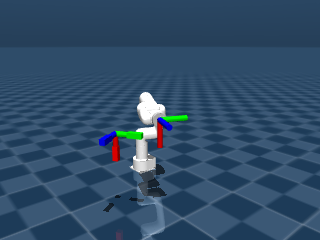
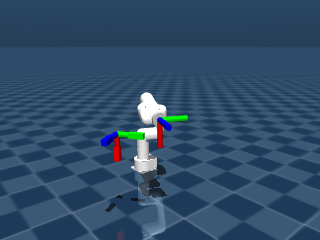
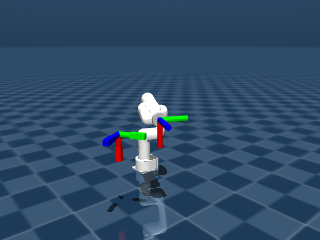
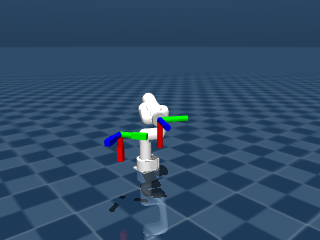
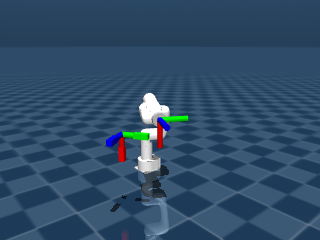
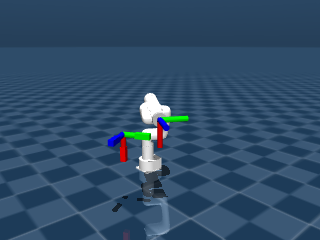
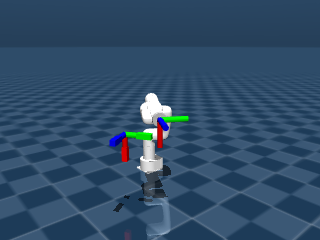
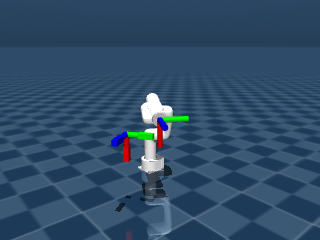
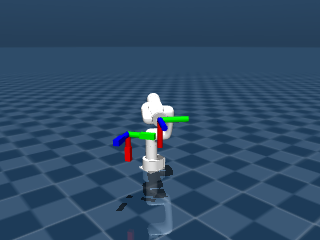
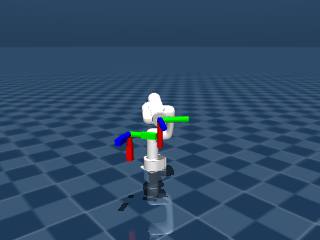
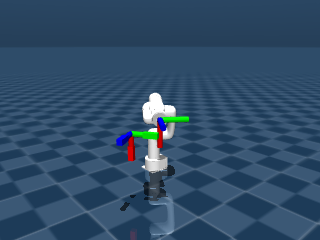
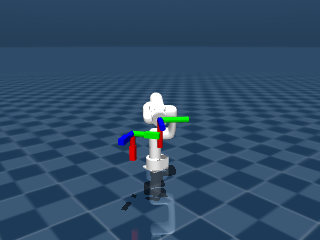
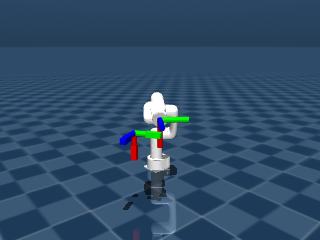
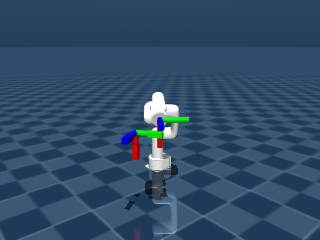
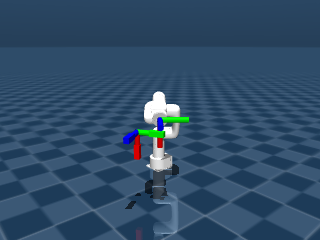
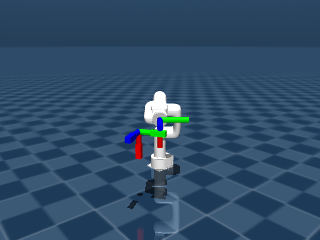
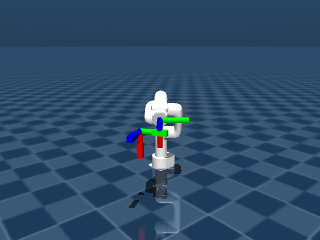
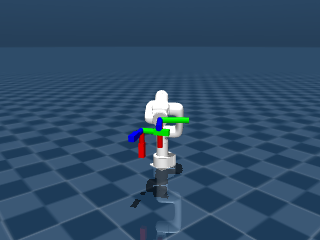
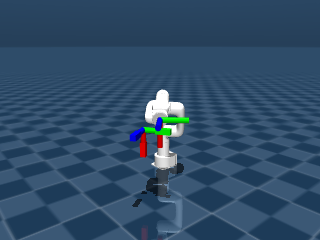
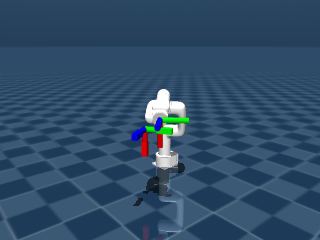
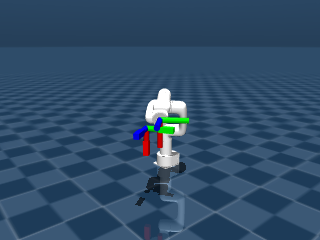
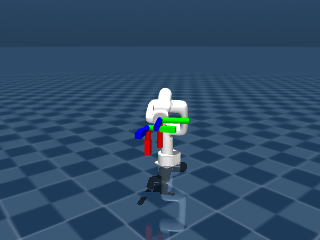
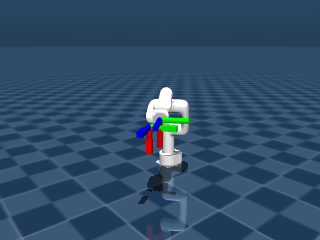
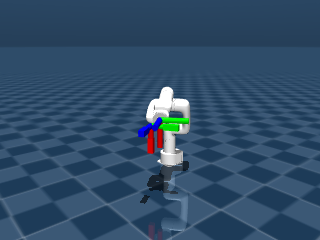
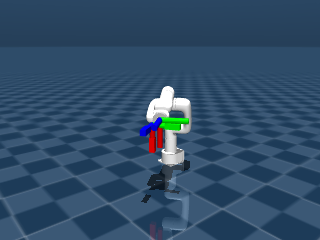
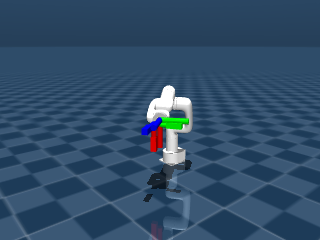
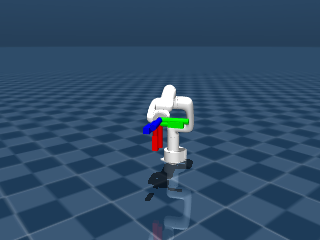
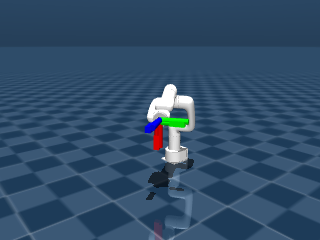
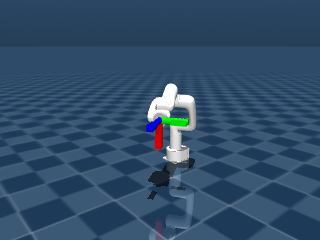
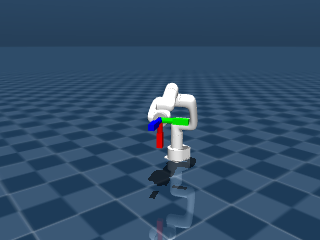

In [522]:
frames = [render_state(x, show=False) for x in angles]
media.show_images(frames)
media.show_video(frames, fps=RATE)

Issues with position control:
- Arm lags behind commands, can't keep up to speed, even with wait=False. The rate dramatically decreases a few seconds in to the trajectory.
- Starts to skip at the end of the trajectory, guessing that there's a queue of all the poses sent which overflows
- Has a stepwise motion which becomes fairly fine and unnoticeable at higher rates (200Hz) but it's still there and not as smooth as it could be


In [117]:
arm.motion_enable(False)

0

# Velocity control

Time to get smooth motion

In [210]:
def twist_faceout(time, speed=1):
  """
  Rotate around the origin, move up and down, keep end effector facing outwards
  Args:
    time: time in seconds at which to calculate the pose
    speed: a factor by which to speed up the motion (or slow it down)
    init_quat: an initial rotation. The default gets z of the end effector facing outwards
  """

  vel = np.array([0.4 * np.cos(speed*time)*speed,
         -0.4 * np.sin(speed*time)*speed,
         0.1 * np.cos(3 * speed*time) * 3 * speed])
  # Angula velocity around z axis
  thetadot = -speed
  w = np.array([0, 0, thetadot])
  
  return vel, w

In [435]:

# Reset the camera, make the arm point straight up.
# camera.distance = 1.5
# camera.elevation = -15
# camera.azimuth = -130
# camera.lookat = (0, 0, 0.3)
# mujoco.mj_resetData(model, data)

init_pos, init_quat = spin_motion(0)
target_id = model.body('target').mocapid
site_id = data.site('attachment_site').id

In [420]:
# Render a video of the generated target path in mujoco

DURATION = 5          # seconds
FRAMERATE = 60        # Hz

mujoco.mj_resetData(model, data)
data.mocap_pos[target_id] = init_pos
data.mocap_quat[target_id] = init_quat
mujoco.mj_forward(model, data)

frames = []
while data.time < DURATION:
  # Move the target
  vel, w = twist_faceout(data.time)
  data.mocap_pos[id] += np.array(vel) * model.opt.timestep

  # angular velocity w is in the base frame, so we have to convert to target frame before integrating
  w_rot = np.zeros(3)
  init_quat_inv = np.array((init_quat[0], -init_quat[1], -init_quat[2], -init_quat[3]))
  mujoco.mju_rotVecQuat(w_rot, w, init_quat_inv)

  qdiff = np.zeros(4)
  qcurr = data.mocap_quat[id][0, :]
  mujoco.mju_quatIntegrate(qcurr, w_rot, model.opt.timestep)
  data.mocap_quat[target_id] = np.atleast_2d(qcurr)
  
  mujoco.mj_step(model, data)

  if len(frames) < data.time * FRAMERATE:
    renderer.update_scene(data, camera, voption)
    frames.append(renderer.render())


media.show_video(frames)

In [111]:
def mujoco_to_xarm_twist(vel, w):
  """
  Convert from position (in m) and quaternion to xarm axis-angle pose [x (mm), y (mm), z (mm), ax, ay, az]
  """
  vel_mm = np.array(vel)*1e3
  return list(vel_mm) + list(w)

In [1]:
# def twist_waypoints:

from scipy.linalg import logm, expm
def twist_interp(T_start, T_end, t, end_time):
  """ 
  Screw interpolation calculates a constant twist to get from the start pose to the end pose in the given time.
  This function calculates the pose at a given time t along the trajectory, using our time scaling s(t) from before.
  Args:
    T_start: start pose, as a 4x4 transform matrix
    T_end: end pose, as a 4x4 transform matrix
    t: the time at which to s
  """
  assert(t >= 0 and t <= end_time)
  s_0, s_1, _ = s(t, end_time)
  return T_start @ expm(logm(invert_tf_matrix(T_start)@T_end)*s_0)*s_1

# Tests
# TODO: set test values
# assert(np.allclose(screw_interp(Tinit, Tcurr, 0, 3), Tinit))

# print(f"End interp:\n{screw_interp(Tinit, Tcurr, 3, 3)}\nEnd pose:\n{Tcurr}")
# # np.isclose(screw_interp(Tinit, Tcurr, 3, 3), Tcurr)
# assert(np.allclose(screw_interp(Tinit, Tcurr, 3, 3), Tcurr))
    

In [36]:
twist_interp(Tinit, Tcurr, 1.5, 3)

array([[ 0.333, -0.333, -0.167, -0.028],
       [-0.167, -0.333,  0.333,  0.109],
       [-0.333, -0.167, -0.333,  0.085],
       [ 0.   ,  0.   ,  0.   ,  0.5  ]])

In [ ]:
end_time = 3
twists = [twist_interp(Tinit, Tcurr, t, end_time) for t in np.linspace(0, end_time, 21)]
plt.plots(twists)

In [252]:
arm.set_mode(0)
arm.set_state(state=0)
time.sleep(1)

code, state = arm.get_servo_angle()
init_x = solve_ik(*spin_motion(0), np.array(state)[:6])
arm.set_servo_angle(angle=init_x, speed=10, wait=True)

arm.set_mode(5)
arm.set_state(state=0)
time.sleep(1)

# Joint vel control
print("ready")

DURATION = 30
RATE = 10 

t = 0
buff_len = int(RATE / 2)
tdiff = collections.deque(maxlen=buff_len)

xprev = init_x
start_time = time.time()
while time.time() < start_time + DURATION:
  if (arm.has_error):
    print(f"Exiting, error {arm.error_code}")
    break
  
  loop_start = time.time()
  t_prev = t
  t = loop_start - start_time

  # Print publish rate every 0.5s
  if (len(tdiff) > 0) and int(t*2) != int(t_prev*2):
    print(f"Rate: {1.0/np.array(tdiff).mean()}")

  vel, w = twist_faceout(t, speed=0.8)
    
  arm.vc_set_cartesian_velocity(speeds=mujoco_to_xarm_twist(vel, w), duration=0.5)
  # render_state(x)
  sleep_time = loop_start + 1.0/RATE - time.time()
  if sleep_time > 0:
    time.sleep(sleep_time)

  tdiff.append(t - t_prev)
  xprev = x.copy()

ready
Rate: 12.195388883752114
Rate: 9.625690146844248
Rate: 9.674107239647219
Rate: 9.423661516906314
Rate: 9.648803487856364
Rate: 9.629831671538632
Rate: 9.518391585571038
Rate: 9.609855321902238
Rate: 9.683389504003516
Rate: 9.673861800656317
Rate: 9.59079935370838
Rate: 9.60671661003222
Rate: 9.51900940484404
Rate: 9.684811557017332
Rate: 9.76209583569959
Rate: 9.544774125660565
Rate: 9.525637642300758
Rate: 9.583261170864429
Rate: 9.65922495059045
Rate: 9.691462288063729
Exiting, error 22


In [154]:
arm.clean_error()

0

In [433]:
arm.motion_enable(False)

0

In [414]:
# Now solve for the joint angles at each pose, move the arm, and visualise the solution
model.opt.timestep = 0.002

DURATION = 10          # seconds
FRAMERATE = 60        # Hz
frames = []
mujoco.mj_resetData(model, data)
init_pos, init_quat = spin_motion(0, speed=1)
x0 = solve_ik(init_pos, init_quat, np.array([1.546, 0.541, 1.49 , 2.961, 0.596, 0.203]))
data.qpos = x0
qvel = np.zeros(model.nv)

data.mocap_pos[target_id] = init_pos
data.mocap_quat[target_id] = init_quat

mujoco.mj_forward(model, data)

jac = np.empty((6, model.nv))
twist = np.empty(6)

while data.time < DURATION:
  
  twist[:3], twist[3:] = twist_faceout(data.time, speed=1)

  qvel_prev = qvel.copy()
  
  # Get end-effector site Jacobian.
  mujoco.mj_jacSite(model, data, jac[:3, :], jac[3:, :], site_id)

  # Solve system of equations: J @ qdot = v
  # We could use the minimize.least_squares function as before for minimising J @ qdot - v
  # But because our jacobian here is linear (it is a linearised approximation) and invertible, it is much more efficient and accurate to just solve with decomposition
  # If we wanted to use regularisation terms or nonlinear terms for the residual, we would need to use iterative nonlinear optimisation like minimize.least_squares
  # However, because minimize.least_squares uses Levenberg-Marquardt regularisation, it is more stable around singularities, whereas the decomposition solution may cause the joint to oscillate
  # More here: https://www.cs.cmu.edu/~15464-s13/lectures/lecture6/iksurvey.pdf
  data.qvel = np.linalg.solve(jac, twist)

  # angular velocity w is in the base frame, so we have to convert to target frame before integrating
  # w_rot = np.zeros(3)
  # init_quat_inv = np.array((init_quat[0], -init_quat[1], -init_quat[2], -init_quat[3]))
  # mujoco.mju_rotVecQuat(w_rot, w, init_quat_inv)
  # qdiff = np.zeros(4)
  # qcurr = data.mocap_quat[id][0, :]
  # mujoco.mju_quatIntegrate(qcurr, w_rot, model.opt.timestep)
  # data.mocap_quat[id] = np.atleast_2d(qcurr)
  # data.mocap_pos[id] += np.array(vel) * model.opt.timestep

  # Move the target
  pos, quat = spin_motion(data.time, speed=1)
  data.mocap_pos[id] = pos
  data.mocap_quat[id] = quat

  mujoco.mj_step(model, data)

  if len(frames) < data.time * FRAMERATE:
    renderer.update_scene(data, camera, voption)
    frames.append(renderer.render())

media.show_video(frames, loop=False)

Let's see the difference with a reduced timestep

In [429]:
model.opt.timestep = 5e-5

DURATION = 10          # seconds
FRAMERATE = 60        # Hz
frames = []
mujoco.mj_resetData(model, data)
init_pos, init_quat = spin_motion(0, speed=1)
x0 = solve_ik(init_pos, init_quat, np.array([1.546, 0.541, 1.49 , 2.961, 0.596, 0.203]))
data.qpos = x0

data.mocap_pos[target_id] = init_pos
data.mocap_quat[target_id] = init_quat

mujoco.mj_forward(model, data)

print(model.opt.timestep)

jac = np.empty((6, model.nv))
twist = np.empty(6)

while data.time < DURATION:
  
  twist[:3], twist[3:] = twist_faceout(data.time, speed=1)

  # Get end-effector site Jacobian.
  mujoco.mj_jacSite(model, data, jac[:3, :], jac[3:, :], site_id)

  data.qvel = np.linalg.solve(jac, twist)

  # angular velocity w is in the base frame, so we have to convert to target frame before integrating
  # w_rot = np.zeros(3)
  # init_quat_inv = np.array((init_quat[0], -init_quat[1], -init_quat[2], -init_quat[3]))
  # mujoco.mju_rotVecQuat(w_rot, w, init_quat_inv)
  # qdiff = np.zeros(4)
  # qcurr = data.mocap_quat[id][0, :]
  # mujoco.mju_quatIntegrate(qcurr, w_rot, model.opt.timestep)
  # data.mocap_quat[id] = np.atleast_2d(qcurr)
  # data.mocap_pos[id] += np.array(vel) * model.opt.timestep

  # Move the target
  pos, quat = spin_motion(data.time, speed=1)
  data.mocap_pos[id] = pos
  data.mocap_quat[id] = quat

  mujoco.mj_step(model, data)

  if len(frames) < data.time * FRAMERATE:
    renderer.update_scene(data, camera, voption)
    frames.append(renderer.render())

media.show_video(frames, loop=False)

5e-05


Much nicer. Let's run it on the robotttt

The robot is able to do a full rotation or two at an update rate as low as 5Hz with the speed below 1. Things only get better and smoother higher rates like 50Hz. I couldn't notice any difference between 50 and 200Hz at this speed.
At high speed (~1.5) things get a bit less stable, even at 200Hz. Probably starting to reach joint velocity limits


In [537]:
arm.motion_enable(enable=True)
arm.set_mode(0)
arm.set_state(state=0)
time.sleep(1)

# Very sensitive to initial conditions, get this right!
code, state = arm.get_servo_angle()
# init_x = solve_ik(*spin_motion(0), np.array(state)[:6])
init_x = solve_ik(*spin_motion(0),np.array([1.546, 0.541, 1.49 , 2.961, 0.596, 0.203]))
arm.set_servo_angle(angle=init_x, speed=0.5, wait=True)

arm.set_mode(4)
arm.set_state(state=0)
time.sleep(1)

# Joint vel control
print("ready")

DURATION = 25
RATE = 200

t = 0
buff_len = int(RATE / 2)
tdiff = collections.deque(maxlen=buff_len)

speed = 1.5

code, state = arm.get_servo_angle()
if state[0] < 0:
  print("flip")
  speed = -speed

jac = np.empty((6, model.nv))
twist = np.empty(6)


start_time = time.time()
while time.time() < start_time + DURATION:
  if (arm.has_error):
    print(f"Exiting, error {arm.error_code}")
    break
  
  loop_start = time.time()
  t_prev = t
  t = loop_start - start_time

  # Print publish rate every 0.5s
  if (len(tdiff) > 0) and int(t*2) != int(t_prev*2):
    print(f"Rate: {1.0/np.array(tdiff).mean()}")

  twist[:3], twist[3:] = twist_faceout(t, speed=speed)

  # Set current position in mujoco model
  code, state = arm.get_servo_angle()
  data.qpos = np.array(state[:6])
  mujoco.mj_kinematics(model, data)
  mujoco.mj_comPos(model, data)

  # Get end-effector site Jacobian.
  mujoco.mj_jacSite(model, data, jac[:3, :], jac[3:, :], site_id)

  qvel = np.linalg.solve(jac, twist)
  data.qvel = qvel
    
  arm.vc_set_joint_velocity(speeds=list(qvel), duration=0.5)
  sleep_time = loop_start + 1.0/RATE - time.time()
  if sleep_time > 0:
    time.sleep(sleep_time)

  tdiff.append(t - t_prev)


ready
Rate: 170.48312244256792
Rate: 167.11486381763248
Rate: 168.16013907286893
Rate: 168.6039846185139
Rate: 169.74589739656832
Rate: 169.45245049914956
Rate: 166.7731222882445
Rate: 165.79593872872903
Rate: 169.06080911137053
Rate: 167.2394688438386
[SDK][ERROR][2024-06-18 17:34:21][base.py:380] - - API -> vc_set_joint_velocity -> code=1, speeds=[-1.7125702179468907, 0.27805073023993576, -0.13882175288229912, -0.029633127792818646, 0.4534023296806626, -0.08733751064760592, 0], is_sync=True
[SDK][ERROR][2024-06-18 17:34:21][base.py:380] - - API -> vc_set_joint_velocity -> code=1, speeds=[-1.7138646903030677, 0.2426556088877383, -0.1365713691286156, -0.08239991494628654, 0.420371556358703, -0.03220033876294871, 0], is_sync=True
[SDK][ERROR][2024-06-18 17:34:21][base.py:380] - - API -> vc_set_joint_velocity -> code=1, speeds=[-1.7150539924256336, 0.20591445894377805, -0.13404845860412978, -0.13700023186473934, 0.3858585245285764, 0.024936578713805158, 0], is_sync=True
[SDK][ERROR][2024

In [516]:
state

'xArm is not connect'

In [426]:
screw_to_pos(init_pos, init_quat)

Move from [1.697462, 502.313721, 260.328522, -1.444324, -1.005809, -0.986514] to [1.697462, 502.31372099999993, 260.328522, -1.4443239999999997, -1.0058090000000002, -0.9865139999999999] 
Move from [1.697462, 502.313721, 260.328522, -1.444324, -1.005809, -0.986514] to [-1.7526144954817457, 499.49210838405395, 261.16904359424433, -1.4719762008901545, -0.9443775204170985, -0.9253485350303365] 
Move from [-1.752614, 499.492096, 261.169037, -1.471976, -0.944378, -0.925349] to [-10.714841923544457, 491.87403211527516, 264.76165287123024, -1.5364470245585207, -0.7762413460057822, -0.7580287338292038] 
Move from [-10.714842, 491.874023, 264.761658, -1.536447, -0.776241, -0.758029] to [-22.1716384530034, 480.7208347036182, 273.24703518310525, -1.6040516240811633, -0.5256531550341608, -0.5088815537729119] 
Move from [-22.171638, 480.720825, 273.24704, -1.604052, -0.525653, -0.508882] to [-31.886864246476534, 467.20450578815667, 287.56291212486167, -1.6437146928851554, -0.21881604774139155, -0.2

## Control

Let's use our velocity control but with position feedback so we can stick to the target.

https://www.cs.cmu.edu/~15464-s13/lectures/lecture6/iksurvey.pdf
https://github.com/kevinzakka/mjctrl/blob/main/diffik.py

In [646]:
model.opt.timestep = 0.002

DURATION = 5          # seconds
FRAMERATE = 60        # Hz
frames = []
mujoco.mj_resetData(model, data)
init_pos, init_quat = spin_motion(0, speed=1)
# x0 = solve_ik(init_pos, init_quat, np.array([1.546, 0.541, 1.49 , 2.961, 0.596, 0.203]))
x0 = np.array([1.546, 0.541, 1.49 , 2.961, 0.596, 0.203])
data.qpos = x0
xprev = x0

data.mocap_pos[target_id] = init_pos
data.mocap_quat[target_id] = init_quat

mujoco.mj_forward(model, data)

jac = np.zeros((6, model.nv))
twist = np.empty(6)
error = np.zeros(6)
curr_quat = np.empty(4)
curr_quat_conj = np.empty(4)
quat_err = np.empty(4)
dq = np.zeros(model.nv)

while data.time < DURATION:
  
  target_pos, target_quat = spin_motion(data.time, speed=1)

  method = 4

  if method == 1:
    # Solve for the next pose, and subtract current pose to get dq
    ik_target = lambda x: ik(x, pos=target_pos, quat=target_quat,
                            reg_target=x_prev, radius=0.05, reg=.1)
    # ik_target = lambda x: ik(x, pos=pos, quat=quat, radius=0.05, reg=.1)
    x, _ = minimize.least_squares(x_prev, ik_target, bounds,
                                jacobian=ik_jac,
                                verbose=0)
    dq = x - data.qpos

  else:
    # Solving directly for dq

    # Calculate error term and jacobian
    # Pos error
    error[:3] = target_pos - data.site(site_id).xpos

    # Quat error
    mujoco.mju_mat2Quat(curr_quat, data.site(site_id).xmat)
    mujoco.mju_negQuat(curr_quat_conj, curr_quat)
    mujoco.mju_mulQuat(quat_err, target_quat, curr_quat_conj)
    mujoco.mju_quat2Vel(error[3:], quat_err, 1.0)

    # Get end-effector site Jacobian.
    mujoco.mj_jacSite(model, data, jac[:3, :], jac[3:, :], site_id)
    
    if method == 2:
      dq = np.linalg.solve(jac, error)

    elif method == 3:
      # Solve with LM optimisation
      res = lambda x: jac @ x - error.reshape(-1, 1)
      dq, _ = minimize.least_squares(x - x_prev, res,
                                  verbose=0)
    elif method == 4:
      # Damped least squares taken from https://github.com/kevinzakka/mjctrl/blob/main/diffik.py
      # Damping coefficient
      diag = 1e-4 * np.eye(6)
      # Solve system of equations: J @ dq = error.
      dq = jac.T @ np.linalg.solve(jac @ jac.T + diag, error)

  # We could use qvel and integrate here
  # data.qpos += dq
  data.qvel = dq
  
  # Move the target
  data.mocap_pos[target_id] = target_pos
  data.mocap_quat[target_id] = target_quat

  mujoco.mj_step(model, data)

  x_prev = data.qpos.copy()

  if len(frames) < data.time * FRAMERATE:
    renderer.update_scene(data, camera, voption)
    frames.append(renderer.render())

media.show_video(frames, loop=False)

0.002


The arm follows the path but is clearly lagging. Thus we can add a gain term, Kp, and play around with it to get better tracking.
If it gets too high (>400), the LM dq approach and the undamped approach will stall in finding a solution, but the damped jacobian and the LM q approaches will work, until it gets soo high that the motion is just erratic.
20-100 seems to work fairly nicely

In [663]:
model.opt.timestep = 0.002

DURATION = 5          # seconds
FRAMERATE = 60        # Hz
frames = []
mujoco.mj_resetData(model, data)
init_pos, init_quat = spin_motion(0, speed=1)
# x0 = solve_ik(init_pos, init_quat, np.array([1.546, 0.541, 1.49 , 2.961, 0.596, 0.203]))
x0 = np.array([1.546, 0.541, 1.49 , 2.961, 0.596, 0.203])
data.qpos = x0
xprev = x0

data.mocap_pos[target_id] = init_pos
data.mocap_quat[target_id] = init_quat

mujoco.mj_forward(model, data)

jac = np.zeros((6, model.nv))
twist = np.empty(6)
error = np.zeros(6)
curr_quat = np.empty(4)
curr_quat_conj = np.empty(4)
quat_err = np.empty(4)
dq = np.zeros(model.nv)

Kp = 20

while data.time < DURATION:
  
  target_pos, target_quat = spin_motion(data.time, speed=1)

  method = 3

  if method == 1:
    # Solve for the next pose, and subtract current pose to get dq
    ik_target = lambda x: ik(x, pos=target_pos, quat=target_quat,
                            reg_target=x_prev, radius=0.05, reg=.1)
    # ik_target = lambda x: ik(x, pos=pos, quat=quat, radius=0.05, reg=.1)
    x, _ = minimize.least_squares(x_prev, ik_target, bounds,
                                jacobian=ik_jac,
                                verbose=0)
    dq = x - data.qpos

  else:
    # Solving directly for dq

    # Calculate error term and jacobian
    # Pos error
    error[:3] = target_pos - data.site(site_id).xpos

    # Quat error
    mujoco.mju_mat2Quat(curr_quat, data.site(site_id).xmat)
    mujoco.mju_negQuat(curr_quat_conj, curr_quat)
    mujoco.mju_mulQuat(quat_err, target_quat, curr_quat_conj)
    mujoco.mju_quat2Vel(error[3:], quat_err, 1.0)

    # Get end-effector site Jacobian.
    mujoco.mj_jacSite(model, data, jac[:3, :], jac[3:, :], site_id)
    
    if method == 2:
      dq = np.linalg.solve(jac, error)

    elif method == 3:
      # Solve with LM optimisation
      res = lambda x: jac @ x - error.reshape(-1, 1)
      dq, _ = minimize.least_squares(x - x_prev, res,
                                  verbose=0)
    elif method == 4:
      # Damped least squares taken from https://github.com/kevinzakka/mjctrl/blob/main/diffik.py
      # Damping coefficient
      diag = 1e-4 * np.eye(6)
      # Solve system of equations: J @ dq = error.
      dq = jac.T @ np.linalg.solve(jac @ jac.T + diag, error)

  # We could use qvel and integrate here
  # data.qpos += dq
  data.qvel = Kp*dq
  
  # Move the target
  data.mocap_pos[target_id] = target_pos
  data.mocap_quat[target_id] = target_quat

  mujoco.mj_step(model, data)

  x_prev = data.qpos.copy()

  if len(frames) < data.time * FRAMERATE:
    renderer.update_scene(data, camera, voption)
    frames.append(renderer.render())

media.show_video(frames, loop=False)

Let's run it on the robot. To avoid erratic motion, let's start with a conservative Kp value of 10 and gradually increase.
Anywhere from 20-40 seem to work fairly nicely. However, there's a very sudden start from rest which is quite jarring. A d term would help.

In [669]:
arm.motion_enable(enable=True)
arm.set_mode(0)
arm.set_state(state=0)
time.sleep(1)

# Very sensitive to initial conditions, get this right!
code, state = arm.get_servo_angle()
# init_x = solve_ik(*spin_motion(0), np.array(state)[:6])
init_x = solve_ik(*spin_motion(0),np.array([1.546, 0.541, 1.49 , 2.961, 0.596, 0.203]))
arm.set_servo_angle(angle=init_x, speed=0.8, wait=True)

arm.set_mode(4)
arm.set_state(state=0)
time.sleep(1)

# Joint vel control
print("ready")

DURATION = 25
RATE = 200

t = 0
buff_len = int(RATE / 2)
tdiff = collections.deque(maxlen=buff_len)

speed = 1.2

code, state = arm.get_servo_angle()
if state[0] < 0:
  print("flip")
  speed = -speed

jac = np.empty((6, model.nv))
twist = np.empty(6)
error = np.zeros(6)
curr_quat = np.empty(4)
curr_quat_conj = np.empty(4)
quat_err = np.empty(4)
dq = np.zeros(model.nv)

Kp = 20

start_time = time.time()
while time.time() < start_time + DURATION:
  if (arm.has_error):
    print(f"Exiting, error {arm.error_code}")
    break
  
  loop_start = time.time()
  t_prev = t
  t = loop_start - start_time

  # Print publish rate every 0.5s
  if (len(tdiff) > 0) and int(t*2) != int(t_prev*2):
    print(f"Rate: {1.0/np.array(tdiff).mean()}")

  target_pos, target_quat = spin_motion(t, speed=speed)

  # Set current position in mujoco model
  code, state = arm.get_servo_angle()
  xcurr = np.array(state[:6])
  
  # Solve for J @ dq = error
  # Can  solve with np.linalg or use minimize.least_squares for the stability benefits and bounding
  method = 3

  if method == 1:
    # Solve for the next pose, and subtract current pose to get dq
    ik_target = lambda x: ik(x, pos=target_pos, quat=target_quat,
                            reg_target=xcurr, radius=0.05, reg=.1)
    x, _ = minimize.least_squares(xcurr, ik_target, bounds,
                                jacobian=ik_jac, verbose=0)
    if any(np.isclose(x[0:1], bounds[0][0:1], atol=0.05)) or any(np.isclose(x[0:1], bounds[1][0:1], atol=0.05)):
      print("Aiming past limits, break")
      break

    dq = x - xcurr

  else:
    # Solving directly for dq
    # Calculate error term and jacobian
    data.qpos = xcurr
    mujoco.mj_kinematics(model, data)
    mujoco.mj_comPos(model, data)
    # Pos error
    error[:3] = target_pos - data.site(site_id).xpos

    # Quat error
    mujoco.mju_mat2Quat(curr_quat, data.site(site_id).xmat)
    mujoco.mju_negQuat(curr_quat_conj, curr_quat)
    mujoco.mju_mulQuat(quat_err, target_quat, curr_quat_conj)
    mujoco.mju_quat2Vel(error[3:], quat_err, 1.0)
    # Get end-effector site Jacobian.
    mujoco.mj_jacSite(model, data, jac[:3, :], jac[3:, :], site_id)
    
    if method == 2:
      dq = np.linalg.solve(jac, error)

    elif method == 3:
      # Solve with LM optimisation
      res = lambda x: jac @ x - error.reshape(-1, 1)
      ## TODO: 
      dq, _ = minimize.least_squares(dq, res,
                                  verbose=0)
    elif method == 4:
      # Damped least squares taken from https://github.com/kevinzakka/mjctrl/blob/main/diffik.py
      # Damping coefficient
      diag = 1e-4 * np.eye(6)
      # Solve system of equations: J @ dq = error.
      dq = jac.T @ np.linalg.solve(jac @ jac.T + diag, error)
    
    
  arm.vc_set_joint_velocity(speeds=list(Kp*dq), duration=0.1)
  sleep_time = loop_start + 1.0/RATE - time.time()
  if sleep_time > 0:
    time.sleep(sleep_time)

  tdiff.append(t - t_prev)


[motion_enable], xArm is not ready to move
[set_state], xArm is ready to move


ready
[SDK][ERROR][2024-06-19 11:34:49][base.py:380] - - API -> vc_set_joint_velocity -> code=1, speeds=[-1.2706152163098214, 0.04856679095083255, 0.389449304571291, 0.0009571225350684813, -0.33283667013228113, -0.0012411461965024003, 0], is_sync=True
[SDK][ERROR][2024-06-19 11:34:49][base.py:380] - - API -> vc_set_joint_velocity -> code=1, speeds=[-1.4006653722787064, 0.030127346536724504, 0.37934914822309124, 0.0010782057474757148, -0.3411768841557815, -0.0013832672310246314, 0], is_sync=True
[SDK][ERROR][2024-06-19 11:34:49][base.py:380] - - API -> vc_set_joint_velocity -> code=1, speeds=[-1.5391273194751465, 0.0077293615942300485, 0.36131839673057325, 0.0015159985573560467, -0.3455452008530862, -0.001833590507809341, 0], is_sync=True
[SDK][ERROR][2024-06-19 11:34:49][base.py:380] - - API -> vc_set_joint_velocity -> code=1, speeds=[-1.6799177149279865, -0.017976355874946198, 0.335268683586224, 0.002319419521214127, -0.3452024133854038, -0.0026382542771274213, 0], is_sync=True
[SDK][

[SDK][ERROR][2024-06-19 12:15:07][base.py:168] - - [report-socket] socket read timeout


# Screw trajectory
The simplest way to get from one pose to the other is in a straight line. This involves interpolating between two quaternions to get smoothly from one orientation to the other, whilst simultanesouly interpolate the position linearly, and have your robot at the right pose.

The next step up is to interpolate position and orientation simultaneously via a screw trajectory, which applies a constant twist to get from the start to the end pose. This creates a more looping motion that has less of a tendency to go straight through the centre of the robot and self intersect. But it is just as dumb, there is no collision detection involved.

For a primer on the theory, watch/read the [chapter](https://modernrobotics.northwestern.edu/nu-gm-book-resource/9-1-and-9-2-point-to-point-trajectories-part-1-of-2/#department) on trajectory generation from the Modern Robotics textbook by Kevin Lynch, and Frank Park

### Time scaling
A time scaling _s(t)_ maps a path (a curve to be followed) to a trajectory (a path/poses as a function of time). A short time obviously means that the robot is moves at higher velocity.

A linear time scaling would result in jerky motion at the start and end as the robot would have to instantaneously jump to the initial velocity. Instead, a third order polynomial allows us to ramp the velocity up and down and the start and end smoothly if we pick appropriate coefficients. A 5th order polynomial allows for a smooth ramp of acceleration as well. 

_s(t)_ is in the range [0, 1]

In [15]:
def s(t, end_time):
  """
  Calculate a third order polynomial time scaling s
  s = a0 + a1*t + a2*t^2 + a3*t^3
  where
  s = 0 at t=0 and s=end_time at t=end_time
  sdot is 0 at t=0 and t=end_time

  Vectorised implementation allows caluclation of multiple t values simultaneously

  Args:
    t: a time or array of times for which to calculate s
    end_time: the duration of the trajectory, shorter means faster

  Returns:
    s: s value
    s_1: first derivative of s
    s_2: second derivative of s
  """
  t = np.array(t)
  assert(np.all(t >= 0) and np.all(t <= end_time))
  a0 = 0
  a1 = 0
  a2 = 3/end_time**2
  a3 = -2/end_time**3

  # Constants for s, sdot, sddot
  A = np.array([[a0, a1, a2, a3],
                [a1, 2*a2, 3*a3, 0],
                [2*a2, 6*a3, 0, 0]])

  # Form a matrix of
  # [1,     1,     ...]
  # [t0,    t1,    ...]
  # [t0**2, t1**2, ...]
  # [t0**3, t1**3, ...]
  x = np.ones(t.size)
  for i in range(1, 4):
      x = np.vstack((x, t**i))

  assert(x.shape == (4, t.size))

  s = A @ x
  s_0 = s[0, :]
  s_1 = s[1, :]
  s_2 = s[2, :]
  return s_0, s_1, s_2


Now let's plot the time scaling so you can see its properties

Notice the parabolic sdot (velocity) curve starting and ending at rest. Whereas the acceleration is discontinuous at start and end - which is fine, but if you want the acceleration to smoothly ramp, try a 5th order polynomial.

The next cell defines some functions for turning position and orientation into a homogeneous transform matrix for doing pose interpolation.

In [37]:
def get_tf_matrix(pos, quat):
  if isinstance(quat, np.quaternion):
    quat = quaternion.as_float_array(quat)

  pos = np.reshape(np.atleast_2d(pos), (3, 1))
  R = np.zeros(9)
  mujoco.mju_quat2Mat(R, quat)
  R = np.reshape(R, (3, 3))
  T = np.hstack((R, pos))
  T = np.vstack((T, [0, 0, 0, 1]))
  return T

def tf_matrix_to_pose_quat(T):
  R = T[:3, :3].reshape((9, 1))
  pos = list(T[:3, 3])
  quat = np.zeros(4)
  mujoco.mju_mat2Quat(quat, R)
  return pos, quat

def invert_tf_matrix(T):
  R = T[:3, :3]
  t = T[:3, 3]
  T_inv = np.eye(4)
  T_inv[:3, :3] = R.T
  T_inv[:3, 3] = -R.T @ t
  
  return T_inv

# TODO: set pos, quat test values

Tinit = get_tf_matrix(np.array([0.1, 0.1, 0.1]), np.array([0.5, 0.5, -0.5, 0.5]))
Tinit_inv = invert_tf_matrix(Tinit)
Tinit_recomp = invert_tf_matrix(Tinit_inv)
print(f"Tinit:\n{Tinit}\nTinit_recomp:\n{Tinit_recomp}")

assert(np.allclose(Tinit, Tinit_recomp))

pos, quat = tf_matrix_to_pose_quat(Tinit)
Tinit_recomp = get_tf_matrix(pos, quat)

print(f"Tinit:\n{Tinit}\nTinit_recomp:\n{Tinit_recomp}")
assert(np.allclose(Tinit, Tinit_recomp))


Tinit:
[[ 0.  -1.   0.   0.1]
 [ 0.   0.  -1.   0.1]
 [ 1.   0.   0.   0.1]
 [ 0.   0.   0.   1. ]]
Tinit_recomp:
[[ 0.  -1.   0.   0.1]
 [ 0.   0.  -1.   0.1]
 [ 1.   0.   0.   0.1]
 [ 0.   0.   0.   1. ]]
Tinit:
[[ 0.  -1.   0.   0.1]
 [ 0.   0.  -1.   0.1]
 [ 1.   0.   0.   0.1]
 [ 0.   0.   0.   1. ]]
Tinit_recomp:
[[ 0.  -1.   0.   0.1]
 [ 0.   0.  -1.   0.1]
 [ 1.   0.   0.   0.1]
 [ 0.   0.   0.   1. ]]


Here is our screw interpolation function, which calculates the desired pose at each time

In [ ]:
from scipy.linalg import logm, expm
def screw_interp(T_start, T_end, t, end_time):
  """ 
  Screw interpolation calculates a constant twist to get from the start pose to the end pose in the given time.
  This function calculates the pose at a given time t along the trajectory, using our time scaling s(t) from before.
  Args:
    T_start: start pose, as a 4x4 transform matrix
    T_end: end pose, as a 4x4 transform matrix
    t: the time at which to s
  """
  assert(t >= 0 and t <= end_time)
  return T_start @ expm(logm(invert_tf_matrix(T_start)@T_end)*s(t, end_time)[0])

# Tests
# TODO: set test values
assert(np.allclose(screw_interp(Tinit, Tcurr, 0, 3), Tinit))

print(f"End interp:\n{screw_interp(Tinit, Tcurr, 3, 3)}\nEnd pose:\n{Tcurr}")
# np.isclose(screw_interp(Tinit, Tcurr, 3, 3), Tcurr)
assert(np.allclose(screw_interp(Tinit, Tcurr, 3, 3), Tcurr))
    

End interp:
[[ 1.     0.     0.     0.087]
 [ 0.    -1.     0.    -0.   ]
 [ 0.    -0.    -1.     0.154]
 [ 0.     0.     0.     1.   ]]
End pose:
[[ 1.    -0.     0.     0.087]
 [ 0.    -1.     0.    -0.   ]
 [-0.    -0.    -1.     0.154]
 [ 0.     0.     0.     1.   ]]


Visualise the interpolated poses in Mujoco to see how the trajectory will look

In [33]:
# Tcurr = get_tf_matrix(*xarm_to_mujoco_pose(arm.get_position_aa()[1]))
Tcurr = get_tf_matrix(np.zeroes[6])
Tinit = get_tf_matrix(*spin_motion(0))
screw_waypoints = [screw_interp(Tcurr, Tinit, t, end_time) for t in np.linspace(0, end_time, 11)]

print("Interpolation:")
[print(T) for T in screw_waypoints]
print("Tcurr:")
print(Tcurr)
frames = []
for T in screw_waypoints:
  _, pixels = plot_pose(*tf_matrix_to_pose_quat(T), x0, show=False)
  frames.append(pixels)

media.show_images(frames)
media.show_video(frames, loop=False, fps=len(frames)/end_time)


NameError: name 'get_tf_matrix' is not defined

Now let's run it on the robot!

If you get any errors, run arm.reset() to clear them

In [ ]:
# Get the arm ready for motion
arm = XArmAPI(ip, is_radian=True)
arm.motion_enable(enable=True)
arm.set_mode(0)
arm.set_state(state=0)

init_xarm_aa_pose = mujoco_to_xarm_pose(init_pos, init_quat)

print(f"Curr pos: {curr_xarm_aa_pose}")
print(f"Goal pos: {init_xarm_aa_pose}")

ROBOT_IP: 192.168.1.185, VERSION: v1.12.2, PROTOCOL: V1, DETAIL: 6,9,LI1006,DL1000,v1.12.2, TYPE1300: [0, 0]
change protocol identifier to 3
[motion_enable], xArm is not ready to move
[set_state], xArm is ready to move
Curr pos: [87.0, -0.0, 154.199997, 3.141593, -0.0, -0.0]
Goal pos: [0.0, 400.0, 350.0, -1.209199576156145, 1.2091995761561454, 1.209199576156145]


In [ ]:
arm.set_mode(0)
arm.set_state(state=0)
time.sleep(1)
print("ready")

curr_pos, curr_quat = xarm_to_mujoco_pose(arm.get_position_aa()[1])
Tcurr = get_tf_matrix(curr_pos, curr_quat)
Tinit = get_tf_matrix(*spin_motion(0))

end_time = 3

screw_waypoints = [screw_interp(Tcurr, Tinit, t, end_time) for t in np.linspace(0, end_time, 11)]

for T in screw_waypoints:
  # time.sleep(1)
  next_pose = mujoco_to_xarm_pose(*tf_matrix_to_pose_quat(T))
  print(f"Move from {arm.get_position_aa()[1]} to {next_pose} ")
  arm.set_position_aa(next_pose, speed=200, radius=None, wait=True)

ready
Move from [-64.819702, -316.95401, 325.143066, 1.36205, 1.172681, -1.220693] to [-64.819702, -316.95401, 325.143066, 1.3620500000000002, 1.172681, -1.220693] 
Move from [-64.819702, -316.95401, 325.143066, 1.36205, 1.172681, -1.220693] to [-94.89891107458665, -311.24324175599213, 324.60880714336605, 1.4243330881913514, 1.1281901474965903, -1.2819838499380067] 
Move from [-94.898911, -311.243256, 324.608795, 1.424333, 1.12819, -1.281984] to [-172.95507642445568, -283.1715993838025, 323.6784857584922, 1.5897620206736398, 0.9945295212048961, -1.4456411259967206] 
Move from [-172.955078, -283.1716, 323.678497, 1.589762, 0.99453, -1.445641] to [-271.47396852122534, -211.3261914017058, 323.7465801301031, 1.8219451102260855, 0.76138816257288, -1.6778776563451652] 
Move from [-271.473969, -211.326187, 323.746582, 1.821945, 0.761388, -1.677878] to [-350.546202649479, -86.56839190878152, 326.0639733123418, 2.0794296787098463, 0.415268627589546, -1.9403052238925274] 
Move from [-350.546204,

In [ ]:
def screw_to_pos(pos, quat, end_time=3):
  arm.set_mode(0)
  arm.set_state(state=0)
  time.sleep(1)
  
  curr_pos, curr_quat = xarm_to_mujoco_pose(arm.get_position_aa()[1])
  Tstart = get_tf_matrix(curr_pos, curr_quat)
  Tend = get_tf_matrix(pos, quat)

  screw_waypoints = [screw_interp(Tstart, Tend, t, end_time) for t in np.linspace(0, end_time, 11)]

  for T in screw_waypoints:
    # time.sleep(1)
    next_pose = mujoco_to_xarm_pose(*tf_matrix_to_pose_quat(T))
    print(f"Move from {arm.get_position_aa()[1]} to {next_pose} ")
    arm.set_position_aa(next_pose, speed=200, radius=None, wait=True)